In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from torch_nf.systems import Mat
import scipy.stats

In [2]:
d = 3
mat = Mat(d)
T_x0 = np.array([[d/2, 0.]])
eps = [2., 0.02]

In [3]:
class GaussianProposal(object):
    def __init__(self, Sigma, lb, ub):
        self.D = lb.shape[0]
        self.Sigma = Sigma
        self.lb = lb
        self.ub = ub
        self.L = np.linalg.cholesky(Sigma)


    def rvs(self, mu, M=1):
        zs = []
        count = 0
        while (count < M):
            omega = np.random.normal(0., 1., (self.D,))
            z = np.matmul(self.L, omega) + mu
            if np.logical_and(self.lb < z, z < self.ub).all():
                zs.append(z)
                count += 1
        return np.concatenate(zs, axis=0)

    def pdf(self, z, mu):
        dist = scipy.stats.multivariate_normal(mean=mu, cov=self.Sigma)
        return dist.pdf(z)
    
    def logpdf(self, z, mu):
        dist = scipy.stats.multivariate_normal(mean=mu, cov=self.Sigma)
        return dist.logpdf(z)

Sigma = (0.25**2)*np.eye(mat.D)
mu = np.zeros((mat.D,))
proposal = GaussianProposal(Sigma, mat.lb, mat.ub)
z = proposal.rvs(mu, 1)

In [4]:
def ABC_MCMC(N, system, proposal, T_x0, eps):
    count = 0
    z_last = system.prior.rvs(1)
    zs = []
    T_xs = []
    n_sims = 0
    while count < N:
        z = proposal.rvs(z_last)
        T_x = system.simulate(z)
        abc_accept = system.abc_accept(T_x, T_x0, eps)
        if abc_accept:
            log_p_z = system.prior.logpdf(z)
            log_p_z_last = system.prior.logpdf(z_last)
            log_q_z_z_last = proposal.logpdf(z, z_last[0,:])
            log_q_z_last_z = proposal.logpdf(z_last, z[0,:])
            log_mh_ratio = log_p_z + log_q_z_last_z - log_p_z_last - log_q_z_z_last
            if (log_mh_ratio < 0):
                alpha = np.exp(log_mh_ratio)
                if np.random.uniform(0., 1.) < alpha:
                    zs.append(z[0])
                    T_xs.append(T_x[0])
                    z_last = z
                    count += 1
            else:
                zs.append(z[0])
                T_xs.append(T_x[0])
                z_last = z
                count += 1
        n_sims += 1
        print('count=%d\r' % count, end="")
    return np.array(zs), np.array(T_xs)

In [5]:
np.random.seed(3)
N = 1000
zs, T_xs = ABC_MCMC(N, mat, proposal, T_x0, eps)

In [45]:
Sigma = (0.25**2)*np.eye(mat.D)
proposal = GaussianProposal(Sigma, mat.lb, mat.ub)

eps1 = [10, 1.]
epsT = [2, 0.02]
T = 20

In [46]:
all_eps = np.stack([np.linspace(eps1[i], epsT[i], T) for i in range(len(eps1))], axis=1)
print(all_eps.shape)

(20, 2)


In [72]:
def ABC_SMC(N, system, proposal, T_x0, all_eps):
    T = all_eps.shape[0]
    z_last = system.prior.rvs(N)
    zs = [z_last]
    T_xs = [system.simulate(z_last)]
    n_sims = 0
    for t in range(T):
        eps = all_eps[t]
        z_t = []
        T_x_t = []
        for i in range(N):
            count = 0
            while(True):
                z_i = proposal.rvs(z_last[i])
                T_x = system.simulate(z_i[None, :])
                abc_accept = system.abc_accept(T_x, T_x0, eps)
                if abc_accept:
                    z_t.append(z_i)
                    T_x_t.append(T_x[0])
                    break
                count += 1
                print('t=%d, i=%d, count=%d\r' % (t, i, count), end="")
        zs.append(np.array(z_t))
        T_xs.append(np.array(T_x_t))
    print(T_xs[0].shape, T_xs[1].shape)
        
    return np.array(zs), np.array(T_xs)

In [73]:
N = 5
zs, T_xs = ABC_SMC(N, mat, proposal, T_x0, all_eps)

(5, 2) (5, 2)


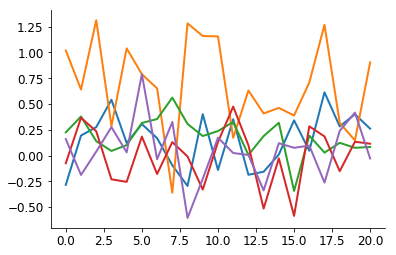

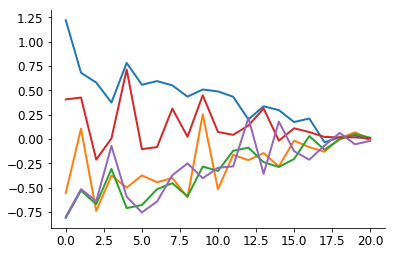

In [80]:
for i in range(T_xs.shape[2]):
    plt.figure()
    plt.plot(T_xs[:,:,i])
    plt.show()

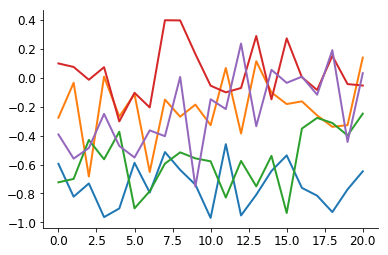

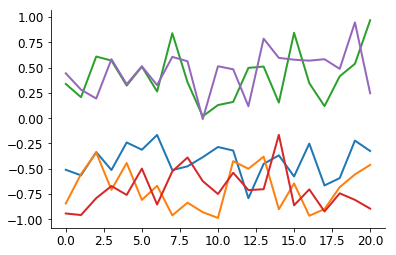

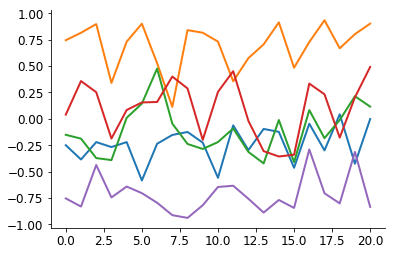

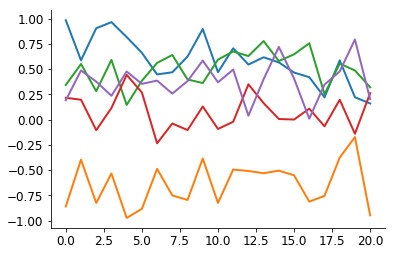

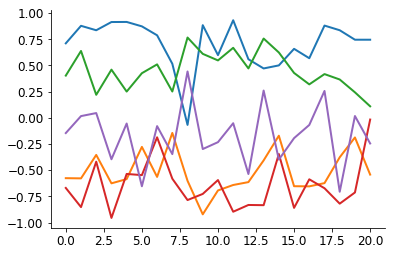

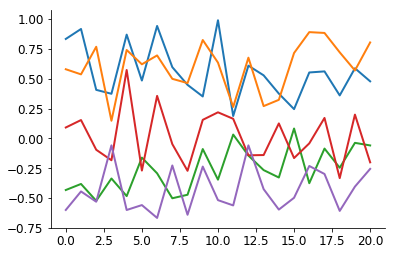

In [78]:
for i in range(mat.D):
    plt.figure()
    plt.plot(zs[:,:,i])
    plt.show()